In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

# Zadanie

Dysponujesz danymi z portalu Our World in Data dotyczącymi:
- Pierwotnej konsumpcji energii
- Emisji CO2 z poszczególnych lat dla różnych krajów

## Część 1: Plik CSV
Utwórz plik CSV zawierający połączone dane dla Polski:
- konsumpcja energii pierwotnej
- emisja CO2
- dane z poszczególnych lat

## Część 2: Plik Excel
Stwórz plik Excel z osobnymi zakładkami dla każdego kraju:
- UE
- USA
- Chiny
- Indie

Każda zakładka powinna zawierać dane o konsumpcji energii i emisji CO2.

## Część 3: Baza danych SQLite
Utwórz bazę danych SQLite z tabelą zawierającą:
- kraj
- rok
- emisja CO2
- konsumpcja energii

Dane powinny obejmować: Polskę, Niemcy i Hiszpanię.

## Część 4: Analiza i wizualizacja
Na podstawie danych z pliku Excel i bazy SQLite utwórz wykresy:
- emisja CO2 w zależności od roku (dla wybranego kraju)
- konsumpcja energii pierwotnej w zależności od roku (dla wybranego kraju)
- **dla chęnych szukanie koreacji**

In [5]:
df_co2 = pd.read_csv("./content/co2-emissions-per-capita.csv")
df_co2.head()

,Entity,Year,Annual CO₂ emissions (per capita)
0,Afghanistan,1949,0.001992
1,Afghanistan,1950,0.010837
2,Afghanistan,1951,0.011625
3,Afghanistan,1952,0.011468
4,Afghanistan,1953,0.013123


In [6]:
df_primary_energy = pd.read_csv("./content/primary-energy-cons.csv")
df_primary_energy.head()

,Entity,Code,Year,Primary energy consumption (TWh)
0,Afghanistan,AFG,1980,6.337187
1,Afghanistan,AFG,1981,7.289555
2,Afghanistan,AFG,1982,7.889244
3,Afghanistan,AFG,1983,9.882159
4,Afghanistan,AFG,1984,9.929878


In [19]:
df_poland = df_primary_energy[df_primary_energy['Entity'] == 'Poland'].join(df_co2.set_index(['Entity','Year']), on=['Entity',"Year"], validate="one_to_one")
print(df_poland.head())
df_poland.to_csv("./content/poland.csv")

      Entity Code  Year  Primary energy consumption (TWh)  \
9734  Poland  POL  1965                         776.05330   
9735  Poland  POL  1966                         791.17820   
9736  Poland  POL  1967                         814.29987   
9737  Poland  POL  1968                         876.36676   
9738  Poland  POL  1969                         936.06604   

      Annual CO₂ emissions (per capita)  
9734                           7.893703  
9735                           7.996349  
9736                           8.138128  
9737                           8.597721  
9738                           9.076116  


In [29]:
countries = ["European Union (27)","United States","China","India"]

import openpyxl


df_countries = df_primary_energy[df_primary_energy['Entity'].isin(countries)].join(df_co2.set_index(['Entity','Year']), on=['Entity',"Year"], validate="one_to_one")

wb = openpyxl.Workbook()
for country in countries:
  sheet = wb.create_sheet(title=country)
  df_country = df_countries[df_countries['Entity'] == country].reset_index()
  sheet.append(df_country.columns.tolist())
  for row in df_country.values.tolist():
    sheet.append(row)
wb.save("./content/countries.xlsx")


In [32]:
countries = ["Poland","Germany","Spain"]
df_countries = df_primary_energy[df_primary_energy['Entity'].isin(countries)].join(df_co2.set_index(['Entity','Year']), on=['Entity',"Year"], validate="one_to_one")

conn = sqlite3.connect("data.sqlite")
query1 = "DROP TABLE IF EXISTS data;"
query2 = """
    CREATE TABLE data (
        country TEXT,
        year INTEGER,
        energy_consumption REAL,
        co2_emissions REAL
    )
"""
conn.execute(query1)
conn.execute(query2)
conn.commit()

for country in countries:
    df_country = df_countries[df_countries["Entity"] == country]
    df_country = df_country.drop(columns=["Code"]).sort_values(by="Year").reset_index(drop=True)
    stmt = "INSERT INTO data VALUES (?, ?, ?, ?)"
    conn.executemany(stmt, df_country.values.tolist())
    conn.commit()

query3 = "SELECT * FROM data"
df_data = pd.read_sql_query(query3, conn)
print(df_data)
conn.close()

    country  year  energy_consumption  co2_emissions
0    Poland  1965           776.05330       7.893703
1    Poland  1966           791.17820       7.996349
2    Poland  1967           814.29987       8.138128
3    Poland  1968           876.36676       8.597721
4    Poland  1969           936.06604       9.076116
..      ...   ...                 ...            ...
175   Spain  2020          1422.96000       4.443056
176   Spain  2021          1531.89940       4.798705
177   Spain  2022          1592.16550       4.906229
178   Spain  2023          1569.63110       4.625513
179   Spain  2024          1624.24630            NaN

[180 rows x 4 columns]


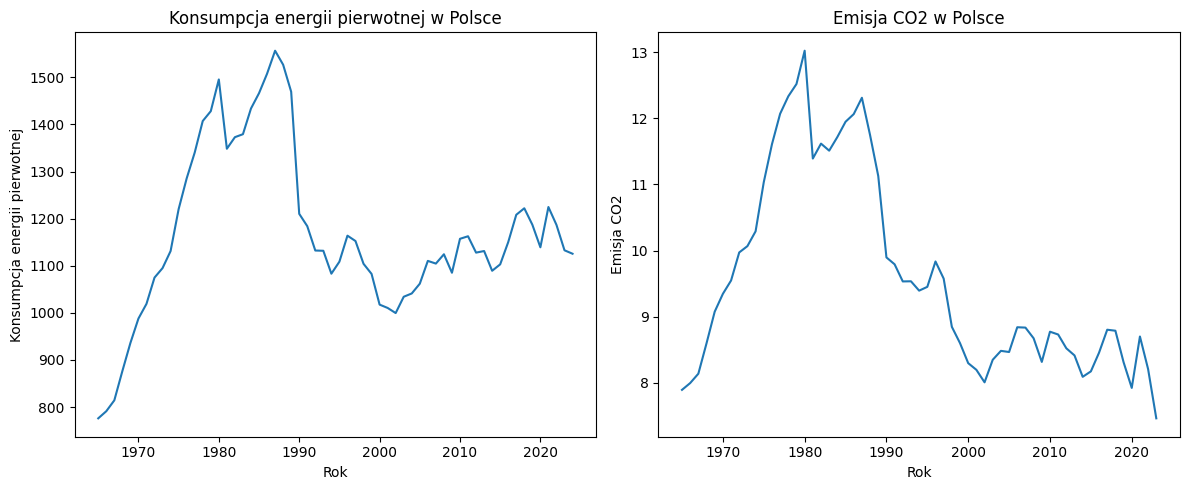

In [44]:
conn = sqlite3.connect("data.sqlite")
query = "SELECT year, energy_consumption, co2_emissions FROM data WHERE country = 'Poland'"
df_data = pd.read_sql_query(query, conn)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(df_data['year'], df_data['energy_consumption'])
axes[0].set_xlabel("Rok")
axes[0].set_ylabel("Konsumpcja energii pierwotnej")
axes[0].set_title("Konsumpcja energii pierwotnej w Polsce")

axes[1].plot(df_data['year'], df_data['co2_emissions'])
axes[1].set_xlabel("Rok")
axes[1].set_ylabel("Emisja CO2")
axes[1].set_title("Emisja CO2 w Polsce")

plt.tight_layout()
plt.show()

conn.close()